Студент Жилкин Федор, 344
# Домашняя работа 4: "Численное решение интегрального уравнения Фредгольма 2-го рода."
**Задания:**

1. Метод замены ядра на вырожденное
2. Метод механических квадратур  

$u(x) + 0.5\int\limits_0^1 e^{xy}u(y)dy = x + 0.5$

In [71]:
import numpy as np
import pandas as pd 
import sympy
import matplotlib.pyplot as plt 

In [4]:
# Функция f(x) справа
def f(x):
    return x + 0.5 

In [5]:
# Ядро
def K(x, y):
    return np.exp(x*y)

## Метод замены ядра на вырожденное

Ядро $e^{xy}$ заменяем на вырожденное ядро: $e^{xy} = \sum\limits^{n}_{k=0}{\frac{(xy)^{k}}{k!}} = \sum\limits^{n}_{k=0}x^k \frac{y^k}{k!} = \sum\limits^{n}_{k=0}a_k(x)b_k(y)$

Отсюда $a_k(x) = x^k$

In [12]:
def integrate_omega(i, j):
    
    """
    Вычисляем интеграл ∫[y^(i+j)/i!]dy
    default: up, down = 1, 0
    """
    
    up, down = 1, 0
    y = sympy.Symbol('y')
    d = sympy.integrate(y**(i+j)/sympy.factorial(i), y)
    res = sympy.lambdify(y, d, 'numpy')
    return res(up) - res(down)

In [13]:
def integrate_beta(i):
    
    """
    Вычисляем интеграл ∫[y^(i)*f(y)/i!]dy
    default: up, down = 1, 0
    """
    
    up, down = 1, 0
    y = sympy.Symbol('y')
    d = sympy.integrate(y**(i)/sympy.factorial(i) * (y + 0.5), y)
    res = sympy.lambdify(y, d, 'numpy')
    return res(up) - res(down)

In [14]:
def degenerate_kernel(n, X):
    
    """
    Решение интегрального уравнения методом замены ядра на вырожденное
    n -- кол-во точек разбиения отрезка
    X -- точка
    default: up, down = 1, 0
    """
    
    # Задаем равномерную сетку
    up, down = 1, 0
    h = (up - down)/n
    x = [(down + i*h) for i in range(0, n)]
    
    A = np.zeros((n, n))
    B = np.zeros(n)
    
    for i in range(0, n):
        for j in range(0, n):
            A[i][j] = int(i==j) - integrate_omega(i, j) # int(i==j) -- Символ Кронекера
        B[i] = integrate_beta(i)
        
    # Искомый вектор C
    C = np.linalg.solve(A, B)
    
    # Решение уравнения
    sum_ = sum([C[i]*(X**i) for i in range(0,n)])
    u = f(X) - 0.5*sum_
    return u

### Тестирование метода замены ядра

In [31]:
def test_degenerate():
    """
    Тестирование метода замены ядра на вырожденное.
    Вычисляем u^3(x), u^4(x) в точках a, (a+b)/2, b
    находим Δ 
    default: up, down = 1, 0
    """
    u_3 = [degenerate_kernel(3, 0), degenerate_kernel(3, 0.5), degenerate_kernel(3, 1)]
    u_4 = [degenerate_kernel(4, 0), degenerate_kernel(4, 0.5), degenerate_kernel(4, 1)]
    delta = np.linalg.norm(list(map(abs, [x - y for x, y in zip(u_3, u_4)])))
    return u_3, u_4, delta

In [90]:
u_3, u_4, delta = test_degenerate()
data = {'$$x$$': ["$$\widetilde{u}^3(x)$$", "$$\widetilde{u}^4(x)$$"],
        "$$a$$": [u_3[0], u_4[0]],
        "$$ \\frac{a+b}{2} $$" : [u_3[1], u_4[1]],
        "$$b$$" : [u_3[2], u_4[2]],
       }
df = pd.DataFrame(data)
df.style.hide_index()

$$x$$,$$a$$,$$ \frac{a+b}{2} $$,$$b$$
$$\widetilde{u}^3(x)$$,2.027630,3.004287,4.120998
$$\widetilde{u}^4(x)$$,1.966109,2.934846,4.091162


**Оценка $\widetilde{\Delta} = 0.09745$**

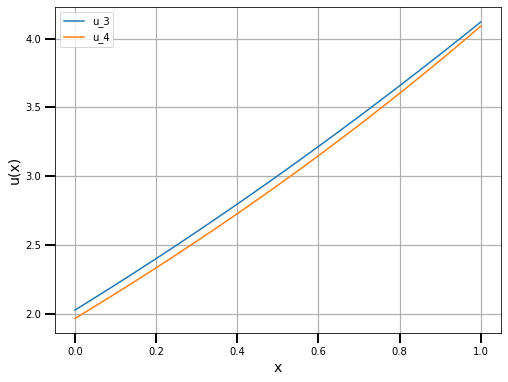

In [92]:
x = [i/100 for i in range(0, 101)]
u_3 = [degenerate_kernel(3, value) for value in x]
u_4 = [degenerate_kernel(4, value) for value in x]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel("x", fontsize=14)        
ax.set_ylabel("u(x)", fontsize=14)
ax.grid(which="major", linewidth=1.2)
ax.grid(which="minor", linestyle="--", color="gray", linewidth=0.5)
ax.plot(x, u_3, label="u_3")
ax.plot(x, u_4, label="u_4")
ax.legend()

ax.xaxis.set_minor_locator(plt.AutoLocator())
ax.yaxis.set_minor_locator(plt.AutoLocator())

ax.tick_params(which='major', length=10, width=2)
ax.tick_params(which='minor', length=5, width=1)
plt.show()

## Метод механических квадратур

In [445]:
def mechanical_quadrature(n, X):
     
    """
    Решение интегрального уравнения методом механических квадратур
    n -- кол-во точек разбиения отрезка
    X -- точка
    default: up, down = 1, 0
    """
    
    # Задаем равномерную сетку
    up, down = 1, 0
    h = (up - down)/n
    x = [(down + i*h) for i in range(0, n)]
    
    A = np.zeros((n, n))
    B = np.zeros(n)
    
    # Веса составной формулы средних прямоугольников
    weights = np.ones(n)*h 
    weights[0] /= 2
    weights[n-1] /= 2
    
    for i in range(0, n):
        for j in range(0, n):
            A[i][j] = int(i==j) - weights[j]*K(x[i], x[j]) # int(i==j) -- Символ Кронекера
        B[i] = f(x[i])
    
    # Искомый вектор Z
    Z = np.linalg.solve(A, B)
    
    # Решение уравнения
    sum_ = sum([weights[i]*K(X, x[i])*Z[i] for i in range(0, n)])
    u = -0.5*sum_ + f(X)
    return u

In [2]:
1923

1923

### Тестирование метода механических квадратур

In [ ]:
def test_degenerate():
    """
    Тестирование метода замены ядра на вырожденное.
    Вычисляем u^3(x), u^4(x) в точках a, (a+b)/2, b
    находим Δ 
    default: up, down = 1, 0
    """
    u_3 = [degenerate_kernel(3, 0), degenerate_kernel(3, 0.5), degenerate_kernel(3, 1)]
    u_4 = [degenerate_kernel(4, 0), degenerate_kernel(4, 0.5), degenerate_kernel(4, 1)]
    delta = np.linalg.norm(list(map(abs, [x - y for x, y in zip(u_3, u_4)])))
    return u_3, u_4, delta